In [7]:
# Imports here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter 
from tqdm import tqdm

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# **Steps**

Step 1: Load Dataset <p>
Step 2: Transform the Dataset <p>
Step 3: Create Model <p>
Step 4: Train Model <p>
Step 5: Save the Model <p>
Step 6: Load the Model <p>

# Step 1: Load Dataset

In [9]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Step 2: Transform the Dataset

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [11]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# Step 3: Create Model

In [12]:
'''class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 102)  # Output layer based on the number of classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x'''

'class TransferLearningModel(nn.Module):\n    def __init__(self):\n        super(TransferLearningModel, self).__init__()\n        self.resnet = models.resnet50(pretrained=True)\n        self.features = nn.Sequential(*list(self.resnet.children())[:-1])\n        self.fc1 = nn.Linear(2048, 1024)\n        self.fc2 = nn.Linear(1024, 512)\n        self.fc3 = nn.Linear(512, 102)  # Output layer based on the number of classes\n\n    def forward(self, x):\n        x = self.features(x)\n        x = x.view(x.size(0), -1)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x'

In [13]:
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        # Use a pre-trained model as the convolutional base
        self.resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # New fully connected layers for classification
        self.fc1 = nn.Linear(2048, 512)  # Adjusted to match ResNet50's output
        self.fc2 = nn.Linear(512, 102)   # Assuming 102 classes for classification
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the pre-trained model's convolutional layers
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
model = TransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #set to ADAM

C:\Users\dinon\Downloads\Testing\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dinon\Downloads\Testing\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Model instantiation and dummy input
model_test = TransferLearningModel()
input_test = torch.randn(64, 3, 224, 224)  # Random input tensor

# Forward pass
output_test = model_test(input_test)
print(output_test.shape)

torch.Size([64, 102])


# Step 4: Train Model

In [16]:
num_epochs = 3

# Initialize lists to store losses and accuracies
train_losses = []
valid_losses = []
accuracies = []

model.train()

writer = SummaryWriter()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        
        inputs, labels = data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(inputs.shape[0], -1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item()}')
            running_loss = 0.0
            
    # Calculate average training loss for this epoch
    epoch_train_loss = running_loss / len(trainloader)
    
    # Validate the model and calculate validation loss and accuracy
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for support_set, query_set in validloader:
            support_set, query_set = support_set.to(device), query_set.to(device)
            embeddings = model(support_set)
            loss = criterion(embeddings, query_set)
            valid_loss += loss.item()
            _, predicted = torch.max(embeddings, 1)
            total += query_set.size(0)
            correct += (predicted == query_set).sum().item()

    epoch_valid_loss = valid_loss / len(validloader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Training', epoch_train_loss, epoch)
    writer.add_scalar('Loss/Validation', epoch_valid_loss, epoch)
    writer.add_scalar('Accuracy/Validation', accuracy, epoch)

    # Store losses and accuracies in the lists
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    accuracies.append(accuracy)

print('Finished Training')

 10%|███████▊                                                                         | 10/103 [01:56<16:46, 10.82s/it]

Epoch [1/3], Step [10/103], Loss: 4.237307071685791


 19%|███████████████▋                                                                 | 20/103 [03:43<14:44, 10.65s/it]

Epoch [1/3], Step [20/103], Loss: 4.165909290313721


 29%|███████████████████████▌                                                         | 30/103 [05:29<12:53, 10.59s/it]

Epoch [1/3], Step [30/103], Loss: 4.056727886199951


 39%|███████████████████████████████▍                                                 | 40/103 [07:14<10:54, 10.39s/it]

Epoch [1/3], Step [40/103], Loss: 3.867367744445801


 49%|███████████████████████████████████████▎                                         | 50/103 [08:57<09:03, 10.25s/it]

Epoch [1/3], Step [50/103], Loss: 3.503383159637451


 58%|███████████████████████████████████████████████▏                                 | 60/103 [10:39<07:19, 10.23s/it]

Epoch [1/3], Step [60/103], Loss: 3.638590097427368


 68%|███████████████████████████████████████████████████████                          | 70/103 [12:22<05:39, 10.29s/it]

Epoch [1/3], Step [70/103], Loss: 3.5215675830841064


 78%|██████████████████████████████████████████████████████████████▉                  | 80/103 [14:05<03:56, 10.29s/it]

Epoch [1/3], Step [80/103], Loss: 3.17828106880188


 87%|██████████████████████████████████████████████████████████████████████▊          | 90/103 [15:48<02:13, 10.27s/it]

Epoch [1/3], Step [90/103], Loss: 3.3133339881896973


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 100/103 [17:31<00:30, 10.25s/it]

Epoch [1/3], Step [100/103], Loss: 3.0915722846984863


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [17:55<00:00, 10.44s/it]


Epoch [1/3] - Training Loss: 0.0937, Validation Loss: 3.4034, Accuracy: 22.49%


 10%|███████▊                                                                         | 10/103 [01:33<14:36,  9.42s/it]

Epoch [2/3], Step [10/103], Loss: 4.761149883270264


 19%|███████████████▋                                                                 | 20/103 [03:06<12:50,  9.29s/it]

Epoch [2/3], Step [20/103], Loss: 4.563647747039795


 29%|███████████████████████▌                                                         | 30/103 [04:39<11:30,  9.45s/it]

Epoch [2/3], Step [30/103], Loss: 4.575536251068115


 39%|███████████████████████████████▍                                                 | 40/103 [06:15<09:58,  9.49s/it]

Epoch [2/3], Step [40/103], Loss: 4.552695274353027


 49%|███████████████████████████████████████▎                                         | 50/103 [07:51<08:44,  9.89s/it]

Epoch [2/3], Step [50/103], Loss: 4.588201999664307


 58%|███████████████████████████████████████████████▏                                 | 60/103 [09:30<07:01,  9.81s/it]

Epoch [2/3], Step [60/103], Loss: 4.4461259841918945


 68%|███████████████████████████████████████████████████████                          | 70/103 [11:06<05:14,  9.53s/it]

Epoch [2/3], Step [70/103], Loss: 4.475988864898682


 78%|██████████████████████████████████████████████████████████████▉                  | 80/103 [12:38<03:31,  9.18s/it]

Epoch [2/3], Step [80/103], Loss: 4.453822135925293


 87%|██████████████████████████████████████████████████████████████████████▊          | 90/103 [14:11<01:59,  9.20s/it]

Epoch [2/3], Step [90/103], Loss: 4.567570686340332


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 100/103 [15:39<00:26,  8.81s/it]

Epoch [2/3], Step [100/103], Loss: 4.582183837890625


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [16:00<00:00,  9.32s/it]


Epoch [2/3] - Training Loss: 0.1311, Validation Loss: 4.4965, Accuracy: 3.42%


 10%|███████▊                                                                         | 10/103 [01:28<13:46,  8.89s/it]

Epoch [3/3], Step [10/103], Loss: 4.355723857879639


 19%|███████████████▋                                                                 | 20/103 [03:02<13:10,  9.53s/it]

Epoch [3/3], Step [20/103], Loss: 4.448667526245117


 29%|███████████████████████▌                                                         | 30/103 [04:41<12:16, 10.09s/it]

Epoch [3/3], Step [30/103], Loss: 4.755415916442871


 39%|███████████████████████████████▍                                                 | 40/103 [06:19<10:10,  9.70s/it]

Epoch [3/3], Step [40/103], Loss: 4.475392818450928


 49%|███████████████████████████████████████▎                                         | 50/103 [07:56<08:35,  9.72s/it]

Epoch [3/3], Step [50/103], Loss: 4.458827018737793


 58%|███████████████████████████████████████████████▏                                 | 60/103 [09:32<06:48,  9.50s/it]

Epoch [3/3], Step [60/103], Loss: 4.50128173828125


 68%|███████████████████████████████████████████████████████                          | 70/103 [11:07<05:15,  9.55s/it]

Epoch [3/3], Step [70/103], Loss: 4.464439392089844


 78%|██████████████████████████████████████████████████████████████▉                  | 80/103 [12:41<03:36,  9.40s/it]

Epoch [3/3], Step [80/103], Loss: 4.40130615234375


 87%|██████████████████████████████████████████████████████████████████████▊          | 90/103 [14:17<02:05,  9.66s/it]

Epoch [3/3], Step [90/103], Loss: 4.49290132522583


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 100/103 [15:50<00:27,  9.31s/it]

Epoch [3/3], Step [100/103], Loss: 4.559694290161133


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [16:12<00:00,  9.44s/it]


Epoch [3/3] - Training Loss: 0.1304, Validation Loss: 4.4754, Accuracy: 3.91%
Finished Training


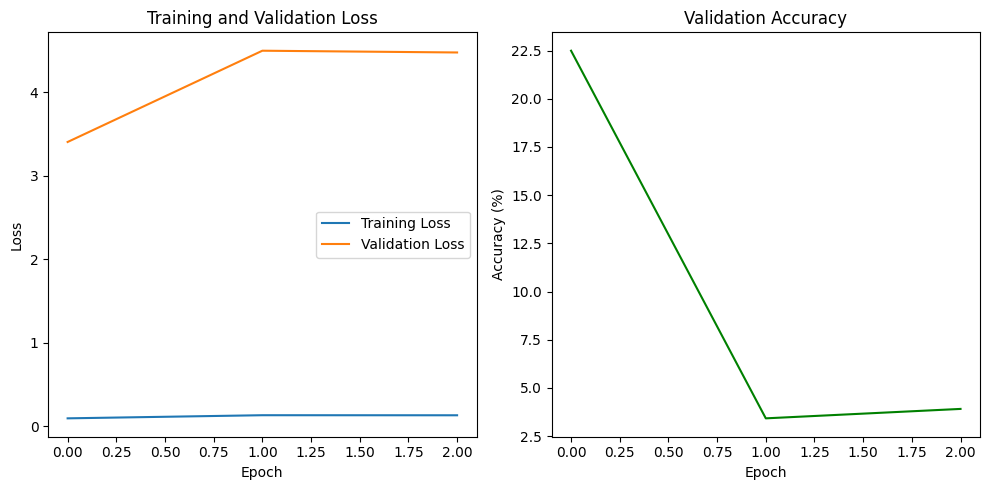

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [18]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 3 %


# Step 5: Save the Model

In [20]:
# Save the trained model to a file
torch.save(model.state_dict(), 'transfer_learning_model.pth')

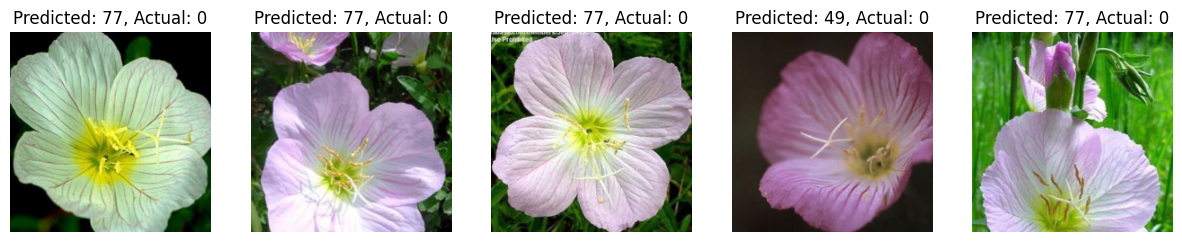

In [21]:
# Set the model to evaluation mode
model.eval()

# Function to display an image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

# Function to make predictions and display images
def visualize_predictions(model, dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, preds = torch.max(output, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        imshow(images[i], ax=axes[i], title=f'Predicted: {preds[i]}, Actual: {labels[i]}')

# Visualize model predictions on a few validation images
visualize_predictions(model, validloader, num_images=5)

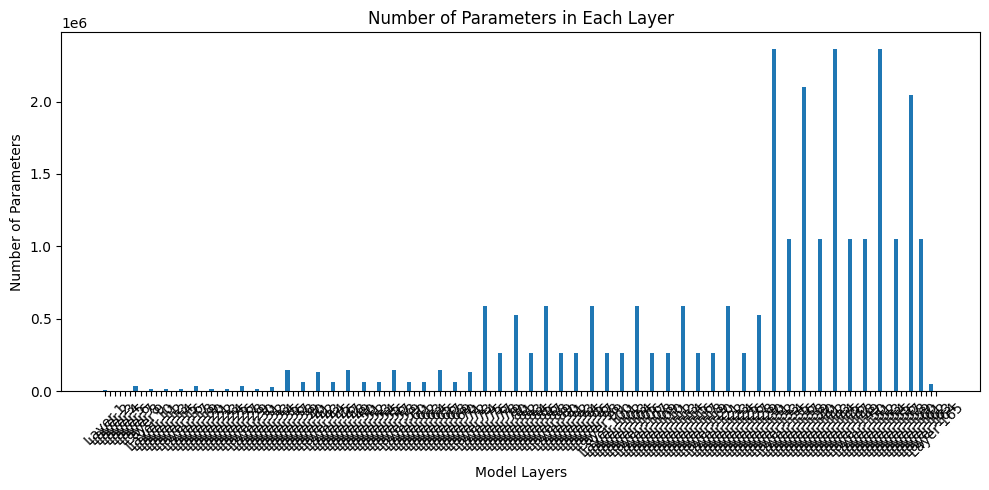

In [22]:
# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()

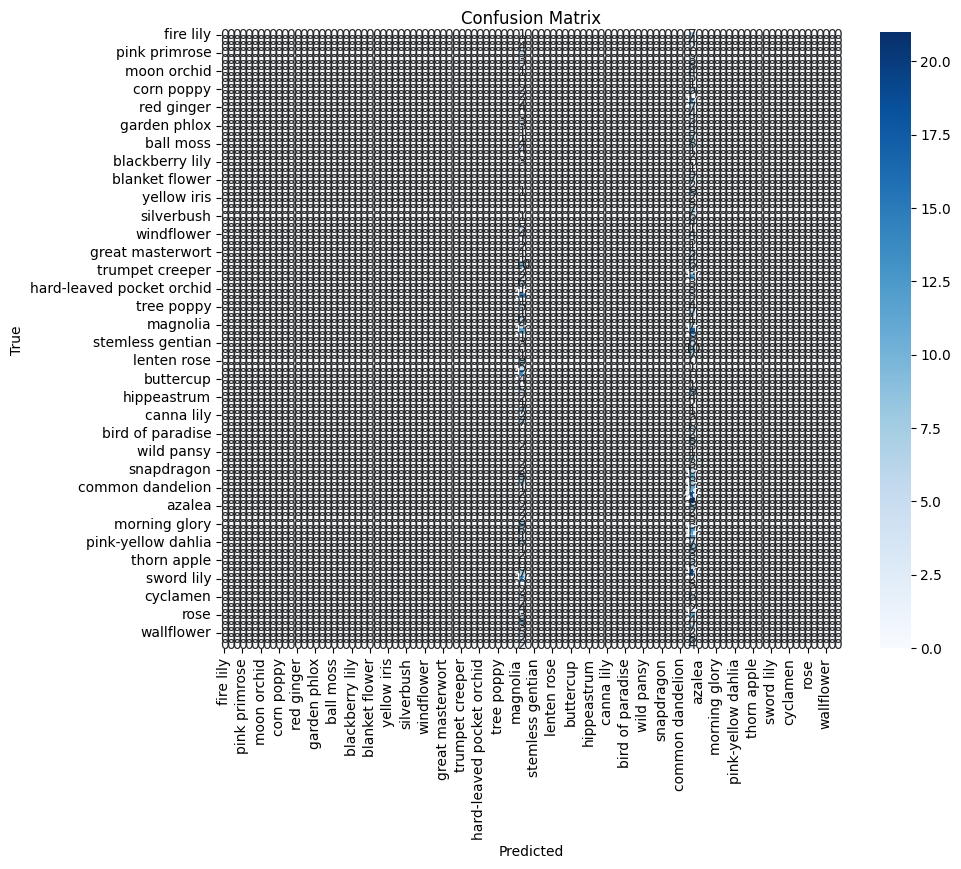

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
writer.close()

In [ ]:
tensorboard --logdir=runs